In [1]:
import medspacy
from IPython.display import Image

In [2]:
from medspacy.visualization import visualize_dep, visualize_ent, MedspaCyVisualizerWidget

# Overview
In the last notebook, we used a statistical NLP model to extract clinical events such as problems, treatments, and tests. However, just because a report mentions a clinical concept doesn't mean that a patient actually has that concept.

Another important task in clinical NLP is **contextual analysis**, which involves looking for contextual modifiers around a concept which indicate whether a concept is:
- Negated
- Historical
- Uncertain
- Experienced by someone other than the patient (such as family history)
- Hypothetical (something that could occur in the future)

## The ConText algorithm
One method for performing this analysis is the **ConText** algorithm. This algorithm was originally proposed in this paper: [Context: An Algorithm for Determining Negation, Experiencer, and Temporal Status from Clinical Reports](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2757457/) by Harkema et al. ConText is an extension of the NegEx algorithm, which is very similar.

There are several implementations of ConText and clinical NLP systems which use ConText, including:
- [cTAKES](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2995668/)
- [Leo](https://department-of-veterans-affairs.github.io/Leo/index.html)
- [pyConText](https://github.com/chapmanbe/pyConTextNLP)

## How ConText works

ConText connects certain **modifiers**, such as **"no evidence of"** or no **"is negative"**, with the target concepts we are extracting. 

---
There is **no evidence of** **_pneumonia_**

---
In this sentence, the **target** is **_pneumonia_**: this is the clinical concept we are trying to extract. The **modifier** is **no evidence of**: this shows that the concept is **negated**. 

ConText finds these targets and modifiers in text and builds **relationships** between them. Here is a visual representation of the graph ConText would create out of this sentence:


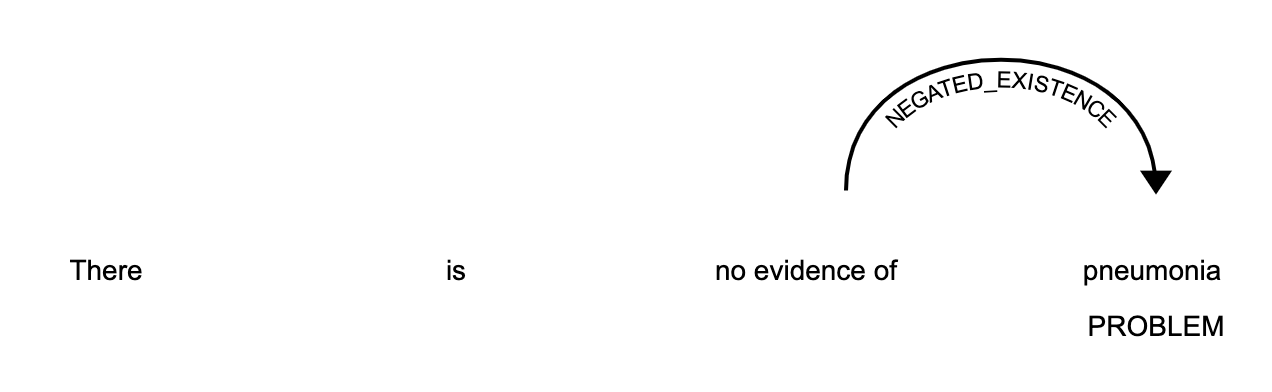

In [3]:
Image("./images/negated_pneumonia.png", width=600)

Likewise, here is another example using family history:

---
There is **_diabetes_** **on her mother's side**

---

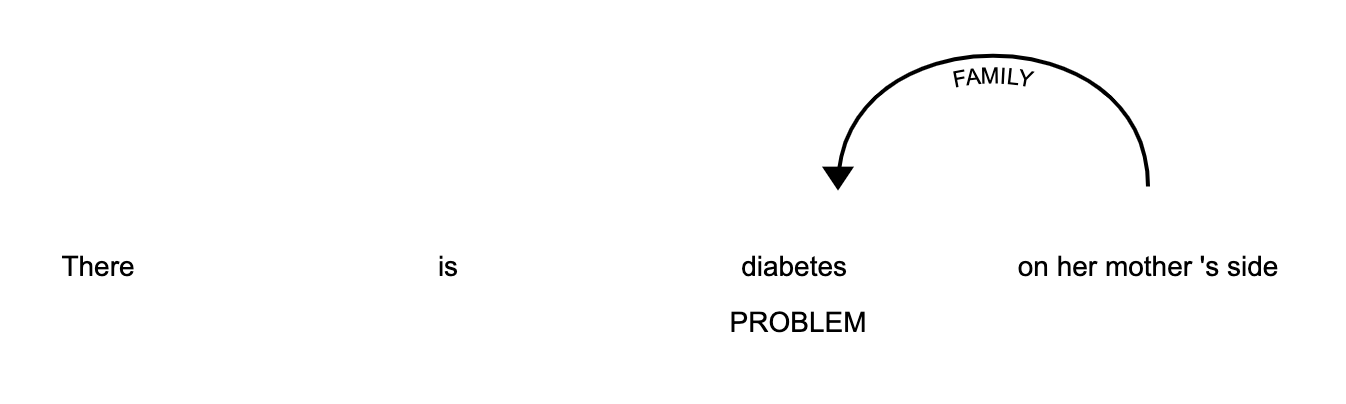

In [4]:
Image("./images/family_history_diabetes.png", width=600)

In both of these examples, finding the clinical problem in the text is not enough: you also need to recognize that the concept is negated or in the patient's family, rather than the patient themself.

# ConText with medspaCy
We will use context by adding it to our NLP pipeline, just like we did with the **EntityRuler**. First, let's load our model in which contains our NER trained to extracted clinical concepts:

In [5]:
nlp = medspacy.load("en_info_3700_i2b2_2012")

/Users/alecchapman/opt/anaconda3/lib/python3.8/site-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_info_3700_i2b2_2012' (0.1.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


We can access the ConText component in the pipeline:

In [6]:
context = nlp.get_pipe("context")

In [7]:
context

In [8]:
context.categories

{'FAMILY',
 'HISTORICAL',
 'HYPOTHETICAL',
 'NEGATED_EXISTENCE',
 'POSSIBLE_EXISTENCE'}

## A simple example
Let's go back to the example we saw in our last notebook. Our NER model correctly identified **"pneumonia"** as a **problem**, but in this sentence it is explicitly negated:

---
There is **no evidence of** **_pneumonia_**

---

Using the ConText algorithm, we can now recognize that this concept is negated. Thanks to the modular nature of spaCy processing pipelines, we don't need to do anything different:

In [9]:
doc = nlp("There is no evidence of pneumonia.")

Let's visualize what the ConText algorithm is doing. MedspaCy offers two functions for visualizing the algorithm. The first function, `visualize_ent`, visualizes the clinical concepts and modifiers in an NER-style visualization, as we saw in the last notebook:

In [10]:
from medspacy.visualization import visualize_dep, visualize_ent

In [11]:
visualize_ent(doc)

The second, `visualize_dep` one visualizes the relationships between targets and modifiers in a dependency-style visualization. Here, we can see that the modifier **"no evidence of"** is applied to the target **"pneumonia"**.

In [12]:
visualize_dep(doc)

When an entity is negated by context, the negation is stored in the `ent._.is_negated` attribute. If `True`, then the concept is negated. By default, it will be `False`.

In [13]:
for ent in doc.ents:
    print(ent, ent._.is_negated)

pneumonia True


## Other attributes
By default, medspaCy will extract the following attributes, which are all False unless the entity is modified by a certain type of modifier:
- `ent._.is_negated`
- `ent._.is_historical`
- `ent._.is_uncertain`
- `ent._.is_family`
- `ent._.is_hypothetical`

Let's see some more examples:

### Historical

In [14]:
doc = nlp("Past medical history significant for nephrectomy.")

In [15]:
visualize_dep(doc)

In [16]:
for ent in doc.ents:
    print(ent, "Historical:", ent._.is_historical)

nephrectomy Historical: True


### Uncertainty

In [17]:
doc = nlp("The scan likely shows a pneumothorax.")

In [18]:
visualize_ent(doc)

In [19]:
visualize_dep(doc)

In [20]:
for ent in doc.ents:
    print(ent, "Uncertain:", ent._.is_uncertain)

The scan Uncertain: False
a pneumothorax Uncertain: True


### Family history

In [21]:
doc = nlp("Her mother had breast cancer.")

In [22]:
visualize_ent(doc)

In [23]:
visualize_dep(doc)

In [24]:
for ent in doc.ents:
    print(ent, "Family:", ent._.is_family)

breast cancer Family: True


### Hypothetical

In [25]:
doc = nlp("She should stop taking warfarin if she develops a rash.")

In [26]:
visualize_ent(doc)

In [27]:
visualize_dep(doc)

In [28]:
for ent in doc.ents:
    print(ent, "Hypothetical:", ent._.is_hypothetical)

warfarin Hypothetical: False
a rash Hypothetical: True


# Creating your own modifiers
We've been using the default knowledge base that comes with context. However, you may want to modify or context's behavior, including adding brand new concepts.

Let's replace our **context** component with a blank instance, then add our own rules.

In [29]:
from medspacy.context import ConTextComponent, ConTextItem

In [30]:
blank_context = ConTextComponent(nlp, rules=None);

In [31]:
# Now replace our old context component with this
if "context" in nlp.pipe_names:
    nlp.remove_pipe("context")
nlp.add_pipe(blank_context)

Let's go back to our first example.

In [32]:
text = "There is no evidence of pneumonia."

## ConTextRule
The modifier rules in context are controlled by `ConTextRule`. A ConTextRule defines what span of text to match as a modifier, how that modifier behaves, and the semantic category of the modifier. It takes these main arguments:
- **`literal`**: The exact text to match
- **`category`**: The semantic category of the modifier, such as **"NEGATED_EXISTENCE"** or **"HISTORICAL"**
- **`direction`**: Which **direction** the modifier should look in the sentence. Look back at the two images at the top of the notebook. In the first example, "There is **no evidence** of **_pneumonia_**", the modifier is **"no evidence"** and it comes before the target concept. In that case, we say it moves **"forward"** in the sentence (to the right). In the other example, "There is **_diabetes_** **on her mother's side**", the modifier comes after the target and we say it moves **backward** in the sentence. This argument in context can take the following values:
    - **"BIDIRECTIONAL"** - This is the default and the modifier will apply to targets on both sides of the modifier
    - **"FORWARD"** - The modifier will modify any targets *after* the modifier
    - **"BACKWARD"** - The modifier will modify any targets *before* the modifier
    - **TERMINATE"** - Any modifiers will stop at this point, such as **"but"** in "No evidence of pneumonia or pleural opacities **but** he has PE."
- **`pattern`**: An optional spaCy pattern to match, like we saw in the pattern-matching notebooks

Let's import the `ConTextRule` from medspaCy.

In [35]:
from medspacy.context import ConTextRule

## Example 1: Negation
Let's create a `ConTextItem` to negate **"pneumonia"** in our first example: "There is **no evidence** of **_pneumonia_**".

### TODO
Create a `ConTextItem` with the following arguments:
- **"no evidence of"**: This will match the phrase in the text
- **"NEGATED_EXISTENCE"**: This is the semantic category
- **"FORWARD"**: The target concept comes *after* the modifier in the sentence

In [37]:
rule = ConTextRule("no evidence of", category="NEGATED_EXISTENCE", direction="FORWARD")

/Users/alecchapman/opt/anaconda3/lib/python3.8/site-packages/medspacy-0.0.1.4-py3.8.egg/medspacy/context/context_rule.py:136: DeprecationWarning: The 'rule' argument from ConTextItem has been replaced with 'direction' in ConTextRule. In the future please use 'direction': ConTextItem(literal, category, direction=...)
  warnings.warn("The 'rule' argument from ConTextItem has been replaced with 'direction' "


We then add a list of ConTextItems to our context object:

In [38]:
blank_context.add([rule])

In [39]:
blank_context.rules

[ConTextRule(literal='no evidence of', category='NEGATED_EXISTENCE', pattern=None, direction='FORWARD')]

Now when we call `nlp` on our text, we can see that **"pneumonia"** is negated by the modifier.

In [40]:
doc = nlp("There is no evidence of pneumonia.")

In [41]:
visualize_ent(doc)

In [42]:
visualize_dep(doc)

## Example 2: Family History

Now let's identify the **family** modifier in "There is diabetes on her mother's side."

### TODO
Create a ConTextRule which will match **"mother's side"** and modify **"diabetes"**. It should have the category **"FAMILY"** and the rule should be **"BACKWARD"**.

In [43]:
doc = nlp("There is diabetes on her mother's side.")
doc.ents

(diabetes,)

In [44]:
item = ConTextRule("mother's side", category="FAMILY", direction="BACKWARD")

/Users/alecchapman/opt/anaconda3/lib/python3.8/site-packages/medspacy-0.0.1.4-py3.8.egg/medspacy/context/context_rule.py:136: DeprecationWarning: The 'rule' argument from ConTextItem has been replaced with 'direction' in ConTextRule. In the future please use 'direction': ConTextItem(literal, category, direction=...)
  warnings.warn("The 'rule' argument from ConTextItem has been replaced with 'direction' "


In [45]:
blank_context.add([rule])

In [46]:
doc = nlp("There is diabetes on her mother's side.")
visualize_ent(doc)

In [47]:
visualize_dep(doc)

## Example 3: Uncertainty
In the phrase below, the physician is considering both **"pneumonia"** and **"bronchitis"** as a diagnosis. In this case, the modifier should go in both directions, not just **"forward"** or **"backward"**.

### TODO
Create a ConTextItem which matches both targets. The category should be **"POSSIBLE_EXISTENCE"** and the rule should be **"BIDIRECTIONAL"**.

In [48]:
doc = nlp("Pneumonia vs bronchitis")
doc.ents

(Pneumonia, bronchitis)

In [49]:
item = ConTextRule("vs", category="POSSIBLE_EXISTENCE", direction="BIDIRECTIONAL")

/Users/alecchapman/opt/anaconda3/lib/python3.8/site-packages/medspacy-0.0.1.4-py3.8.egg/medspacy/context/context_rule.py:136: DeprecationWarning: The 'rule' argument from ConTextItem has been replaced with 'direction' in ConTextRule. In the future please use 'direction': ConTextItem(literal, category, direction=...)
  warnings.warn("The 'rule' argument from ConTextItem has been replaced with 'direction' "


In [50]:
blank_context.add([rule])

In [51]:
doc = nlp("Pneumonia vs bronchitis")
visualize_ent(doc)

In [52]:
visualize_dep(doc)

# Additional examples
Below are a number of additional texts. Go through each of them and process with the NLP. Identify which modifiers should be matched in the sentence and create ConTextItems to connect the modifiers with the targets.

The **category** arguments in the ConTextRules can be:
- "NEGATED_EXISTENCE"
- "POSSIBLE_EXISTENCE"
- "HISTORICAL"
- "HYPOTHETICAL"
- "FAMILY"

And the **rule** arguments can be:
- "BIDIRECTIONAL"
- "FORWARD"
- "BACKWARD"
- "TERMINATE"

In [53]:
rules = [
    ConTextRule("wife", "FAMILY", "FORWARD"),
    ConTextRule("is unknown", "POSSIBLE_EXISTENCE", "BACKWARD"),
    ConTextRule("vs", "POSSIBLE_EXISTENCE", "BIDIRECTIONAL", pattern=[{"LOWER": {"REGEX": "vs\.?"}}]),
    ConTextRule("Past medical history", "HISTORY", "FORWARD"),
    ConTextRule("grandfather", "FAMILY", "FORWARD"),
    ConTextRule("if", "HYPOTHETICAL", "FORWARD"),
    ConTextRule("negative for", "NEGATED_EXISTENCE", "FORWARD"),
]

<>:4: DeprecationWarning: invalid escape sequence \.
<>:4: DeprecationWarning: invalid escape sequence \.
<ipython-input-53-06d702bdc1ec>:4: DeprecationWarning: invalid escape sequence \.
  ConTextRule("vs", "POSSIBLE_EXISTENCE", "BIDIRECTIONAL", pattern=[{"LOWER": {"REGEX": "vs\.?"}}]),


In [54]:
blank_context.add(rules)

In [55]:
texts = [
    "His wife recently died from end stage renal disease.",
    "Whether this is pneumonia is unknown.",
    "Pneumonia vs. bronchitis",
    "Past medical history significant for afib, CHF, and CKD.",
    "Pt's grandfather had prostate cancer.",
    "Stop taking medications if any side effects occur.",
    "The respiratory panel returned negative for influenza.",
    
]

In [56]:
docs = list(nlp.pipe(texts))

In [57]:
w = MedspaCyVisualizerWidget(docs)

In [58]:
# idx = 0
# visualize_dep(docs[idx])
# visualize_ent(docs[idx])

# Next Steps
We now have a fairly comprehensive set of tools for processing clinical text:
1. A pre-trained statistical model which can detect clinical problems, treatments, and tests
2. A rule-based matcher which can extract additional entities which are not extracted by our NER
3. ConText to detect attributes such as negation, temporality, and uncertainty

In our next notebook, we'll put all of this together to analyze an **annotated dataset** and evaluate how well our system works on MIMIC data.


[05-clinical_information_extraction.ipynb](05-clinical_information_extraction.ipynb)